# PROJECT PENGOLAHAN CITRA DIGITAL
---
# Klasifikasi Jenis Serat Kayu Nantu, Palapi, dan Uru Menggunakan GLCM
---
## Disusun Oleh :

  - **KAMILIA ROSADA:** (F1D02310063)
  - **SYA'BANUL MUKARAM:** (F1D02310092)
  - **WADIS FREANDLY:** (F1D02310094)
  - **LALU MUHAMMAD RIZALDI KURNIAWAN:** (F1D02310120)


# Latar Belakang

Proses identifikasi jenis kayu sering kali dilakukan secara manual berdasarkan pengamatan visual terhadap pola serat, warna, dan tekstur permukaan. Namun, metode ini bersifat subjektif dan rentan terhadap kesalahan, terutama ketika jenis kayu memiliki pola serat yang mirip, seperti pada kayu Nantu, Palapi, dan Uru. Ketiga jenis kayu ini banyak digunakan dalam industri lokal, namun sulit dibedakan tanpa keahlian khusus, sehingga dapat menghambat efisiensi produksi atau menyebabkan salah penggunaan material.

Untuk mengatasi hal tersebut, dibutuhkan sistem klasifikasi otomatis berbasis pengolahan citra digital yang mampu mengenali jenis serat kayu secara akurat dan konsisten. Salah satu metode yang efektif untuk mengidentifikasi ciri tekstur pada citra serat kayu adalah Gray Level Co-occurrence Matrix (GLCM). GLCM mampu menggambarkan pola keterhubungan antar piksel pada citra grayscale sehingga menghasilkan fitur tekstur seperti contrast, correlation, homogeneity, dan energy.

Dalam proyek ini, kami menggunakan dataset gambar serat kayu Nantu, Palapi, dan Uru yang diperoleh dari Kaggle untuk membangun sistem klasifikasi berbasis GLCM. Citra-citra tersebut diproses melalui tahapan grayscale, ekstraksi fitur tekstur menggunakan GLCM, dan klasifikasi menggunakan algoritma machine learning seperti K-Nearest Neighbors (KNN), Support Vector Machine (SVM), dan Random Forest. Dengan sistem ini, diharapkan proses identifikasi jenis kayu dapat dilakukan secara lebih cepat, akurat, dan mendukung pengambilan keputusan dalam pengelolaan bahan kayu secara efisien.

# Import Library

Dalam proyek klasifikasi jenis serat kayu Nantu, Palapi, dan Uru menggunakan GLCM, library os dan cv2 digunakan untuk membaca dan mengolah gambar grayscale dari folder masing-masing jenis kayu, sedangkan numpy dan pandas membantu dalam mengubah gambar menjadi array numerik dan menyusun dataset fitur. Ekstraksi fitur tekstur dilakukan menggunakan `graycomatrix` dan `graycoprops` dari `skimage.feature` untuk memperoleh nilai-nilai seperti contrast, homogeneity, energy, dan correlation, serta entropy dari scipy.stats untuk mengukur keacakan citra. Dataset hasil ekstraksi kemudian dibagi menjadi data latih dan uji menggunakan train_test_split, lalu diklasifikasikan dengan algoritma seperti Random Forest, SVM, dan KNN. Evaluasi performa model dilakukan menggunakan metrik seperti akurasi, precision, recall, F1-score, dan confusion matrix melalui sklearn.metrics, sedangkan hasil klasifikasi divisualisasikan dengan bantuan matplotlib.pyplot, ConfusionMatrixDisplay, dan seaborn agar lebih mudah dianalisis secara visual.

In [1]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

# Load gambar

Kode tersebut digunakan untuk membaca dataset citra serat kayu dari direktori bernama serat_kayu, yang di dalamnya terdapat subfolder berdasarkan nama kelas (misalnya Nantu, Palapi, Uru). Program akan menjelajahi setiap subfolder, kemudian membaca setiap gambar di dalamnya. Gambar yang dibaca kemudian diubah menjadi format grayscale menggunakan OpenCV (cv.cvtColor) agar hanya menyimpan informasi intensitas piksel, yang dibutuhkan untuk ekstraksi fitur tekstur. Setiap gambar juga dikonversi ke tipe data uint8 agar sesuai dengan format input yang dibutuhkan metode GLCM.

Setelah citra diproses, gambar tersebut disimpan ke dalam list data, label kelasnya (berdasarkan nama folder) disimpan ke list labels, dan nama file asli citra disimpan ke list file_name untuk referensi jika diperlukan. Setelah semua gambar dibaca, list data dan labels diubah menjadi array NumPy agar bisa lebih mudah digunakan dalam proses pelatihan model machine learning, karena banyak fungsi dari scikit-learn dan NumPy memerlukan data dalam bentuk array. Dengan demikian, kode ini menjadi tahap awal penting dalam proses klasifikasi citra serat kayu karena mempersiapkan data mentah menjadi siap pakai untuk ekstraksi fitur dan klasifikasi.

In [2]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("serat_kayu\\"):
    sub_folder_files = os.listdir(os.path.join("serat_kayu\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("serat_kayu\\", sub_folder, filename)
        img = cv.imread(img_path)
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)


# Preprocessing Percobaan 1

Pada tahapan preprocessing ini, digunakan beberapa metode untuk mempersiapkan citra sebelum analisis lebih lanjut. Proses dimulai dengan resize untuk menyesuaikan ukuran gambar ke dimensi tertentu, dilanjutkan dengan konversi ke grayscale agar lebih sederhana dalam pemrosesan. Setelah itu, dilakukan histogram equalization guna meningkatkan kontras citra. Terakhir, diterapkan median filter sebagai langkah reduksi noise untuk menghilangkan gangguan piksel acak. Seluruh rangkaian ini digunakan dalam percobaan pertama dalam project ini.

In [3]:
def resize(image, target_size):
    target_h, target_w = target_size
    src_h, src_w = image.shape
    resized = np.zeros((target_h, target_w), dtype=np.uint8)

    for i in range(target_h):
        for j in range(target_w):
            src_x = int(i * src_h / target_h)
            src_y = int(j * src_w / target_w)
            resized[i, j] = image[src_x, src_y]

    return resized

Fungsi resize digunakan untuk mengubah ukuran citra ke dimensi yang diinginkan `target_size`. Fungsi ini bekerja dengan cara menghitung posisi piksel sumber `src_x`dan `src_y` berdasarkan skala dari ukuran asli `src_h` dan `src_w` ke ukuran target `target_h` dan `target_w`. Nilai piksel dari posisi tersebut kemudian disalin ke posisi baru dalam citra hasil `resized`. Metode ini dikenal sebagai `nearest neighbor interpolation`, karena mengambil nilai piksel terdekat tanpa melakukan perataan atau interpolasi lanjutan. Hasilnya adalah citra baru dengan ukuran yang sudah diubah sesuai target.

In [4]:
def konversi_grayscale(image):
    if len(image.shape) == 3:
        r, g, b = image[:, :, 0], image[:, :, 1], image[:, :, 2]
        gray = 0.299 * r + 0.587 * g + 0.114 * b
        return gray.astype(np.uint8)
    else:
        return image 

Fungsi `konversi_grayscale` digunakan untuk mengubah citra berwarna menjadi citra grayscale. Fungsi ini memeriksa apakah bentuk citra memiliki tiga dimensi `image.shape' == 3`, yang berarti citra tersebut berformat RGB. Jika ya, maka masing-masing saluran warna — merah `r`, hijau `g`, dan biru `b` — diambil dari citra dan dikombinasikan menggunakan rumus 0.299 * r + 0.587 * g + 0.114 * b. Rumus ini mencerminkan persepsi mata manusia terhadap intensitas cahaya dari tiap warna. Hasilnya adalah citra grayscale yang kemudian dikonversi ke tipe data uint8. Jika citra sudah grayscale, maka fungsi langsung mengembalikan citra tersebut tanpa diubah.

In [5]:
def equalization(image):
    histogram = np.zeros(256, dtype=int)
    h, w = image.shape

    for i in range(h):
        for j in range(w):
            histogram[image[i, j]] += 1

    cdf = np.cumsum(histogram)
    cdf_min = np.min(cdf[np.nonzero(cdf)])
    total_pixels = h * w
    equalized = np.round((cdf[image] - cdf_min) / (total_pixels - cdf_min) * 255)
    equalized = np.clip(equalized, 0, 255).astype(np.uint8)

    return equalized

Fungsi `equalization` digunakan untuk melakukan histogram equalization pada citra grayscale. Pertama, fungsi membuat array histogram berukuran 256 untuk menghitung frekuensi kemunculan tiap nilai intensitas piksel. Ukuran citra disimpan dalam h dan w. Kemudian, fungsi menghitung cdf (cumulative distribution function) dari histogram, dan mengambil nilai minimum pertama yang tidak nol atau cdf_min. Nilai cdf ini digunakan untuk menghitung nilai intensitas baru bagi setiap piksel berdasarkan rumus normalisasi yaitu (cdf[image] - cdf_min) / (total_pixels - cdf_min) * 255. Hasilnya dipotong agar tetap dalam rentang 0–255 dengan `np.clip` dan dikonversi ke tipe uint8. Citra hasilnya memiliki distribusi intensitas yang lebih merata sehingga kontrasnya meningkat.

In [6]:
def reduce_noise(image, kernel_size=3):
    pad = kernel_size // 2
    padded = np.pad(image, pad, mode='edge')
    h, w = image.shape
    output = np.zeros_like(image)
    for i in range(h):
        for j in range(w):
            region = padded[i:i+kernel_size, j:j+kernel_size].flatten()
            sorted_region = np.sort(region)
            median = sorted_region[len(sorted_region) // 2]
            output[i, j] = median
    return output.astype(np.uint8)

Fungsi `reduce_noise` digunakan untuk mengurangi noise pada citra grayscale menggunakan metode median filter dengan ukuran kernel yang dapat ditentukan, default-nya adalah 3. Citra diberi padding dengan metode edge agar ukuran tetap sama setelah proses filter. Untuk setiap piksel, diambil region seukuran kernel di sekitarnya, lalu nilai-nilai dalam region diurutkan menggunakan `np.sort`. Nilai median dari region tersebut diambil dan disimpan sebagai nilai piksel pada citra output. Pendekatan ini efektif dalam menghilangkan noise impuls seperti salt-and-pepper tanpa mengaburkan tepi objek secara signifikan.

In [7]:
dataPreprocessed = []

for i in range(len(data)):
    img = data[i] # ambil data gambar

    # 1. Resize
    img = resize(img, (256,256))

    # 2. Konversi ke grayscale
    img = konversi_grayscale(img)

    # 3. Histogram Equalization untuk meningkatkan kontras
    img = equalization(img)

    # 4. Noise reduction
    img = reduce_noise(img)

    # Simpan hasil akhir preprocessing
    dataPreprocessed.append(img)

Kode tersebut melakukan proses preprocessing pada sekumpulan data gambar yang disimpan dalam variabel `data`. Untuk setiap gambar, dilakukan beberapa tahapan: pertama, gambar diubah ukurannya menjadi 256x256 piksel. Kedua, gambar dikonversi ke dalam format grayscale, sehingga hanya memiliki satu kanal warna untuk menyederhanakan analisis. Ketiga, dilakukan histogram equalization untuk meningkatkan kontras gambar, yang membantu memperjelas fitur penting dalam gambar. Keempat, gambar difilter untuk mengurangi derau (noise) yang dapat mengganggu proses analisis lebih lanjut. Gambar hasil akhir dari tiap tahapan ini kemudian disimpan ke dalam list `dataPreprocessed`.


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Kode dibawah berfungsi untuk menampilkan visualisasi 5 gambar pertama dari setiap kelas atau label yang ada di dataset yang sudah melalui preprocessing. Pertama, kode mengambil daftar label unik dari variabel labels, yang merepresentasikan jenis-jenis serat kayu yaitu Nantu, Palapi, Uru. Kemudian, dibuat figure atau area gambar dengan ukuran yang disesuaikan agar semua gambar dapat terlihat dengan jelas.

Setiap baris pada tampilan ini mewakili satu label, dan setiap baris akan menampilkan 5 gambar pertama yang termasuk ke dalam label tersebut. Kode menggunakan plt.subplot untuk mengatur posisi gambar secara grid (baris dan kolom), sehingga gambar-gambar tersebut tertata rapi. Fungsi imshow digunakan untuk menampilkan gambar yang sudah diproses sebelumnya yaitu `dataPreprocessed`, dengan warna grayscale `cmap='gray'`.

Setiap gambar juga diberi judul yang menunjukkan label (jenis kayu) dan nama file gambar (file_name[idx]) agar kamu mudah mengenali gambar tersebut. Setelah semua gambar siap, fungsi `plt.tight_layout()` memastikan tata letak gambar tidak saling tumpang tindih, dan `plt.show()` menampilkan semua gambar tersebut secara keseluruhan di jendela visualisasi. Jadi kamu bisa melihat bagaimana bentuk dan tekstur serat kayu dari masing-masing kelas sebelum proses selanjutnya.

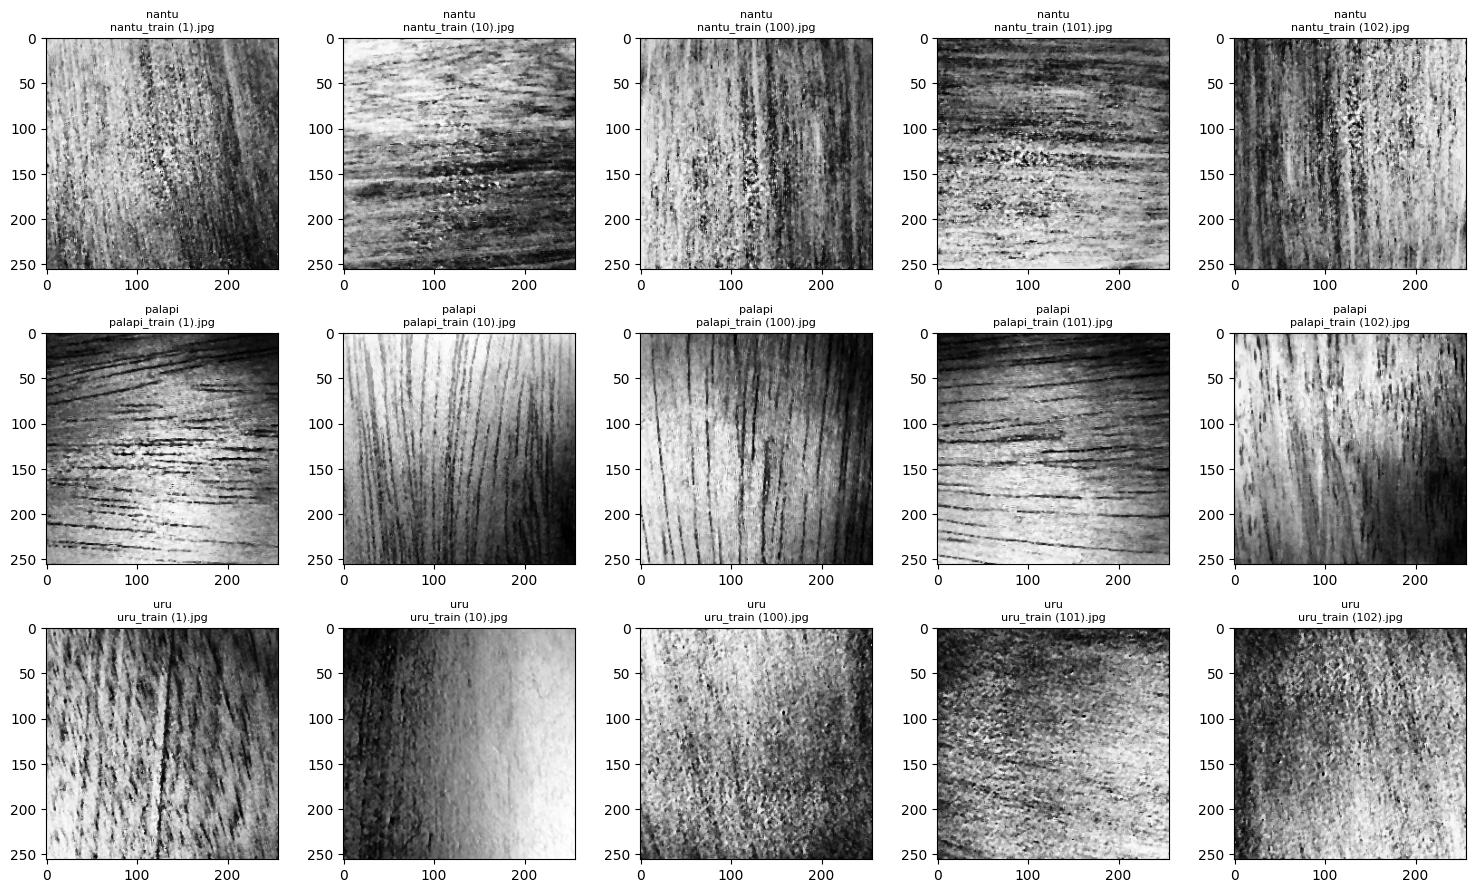

In [8]:
# Visualisasi 5 citra pertama dari setiap label
unique_labels = np.unique(labels)
plt.figure(figsize=(15, 3 * len(unique_labels)))
for i, label in enumerate(unique_labels):
    idxs = np.where(labels == label)[0][:5]  # ambil 5 index pertama dari label tsb
    for j, idx in enumerate(idxs):
        plt.subplot(len(unique_labels), 5, i * 5 + j + 1)
        plt.imshow(dataPreprocessed[idx], cmap='gray')
        plt.title(f"{label}\n{file_name[idx]}", fontsize=8)

plt.tight_layout()
plt.show()

# Ekstraksi GLCM

In [9]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

Fungsi glcm pada kode tersebut digunakan untuk menghasilkan matriks Gray Level Co-occurrence Matrix (GLCM) dari sebuah citra grayscale berdasarkan sudut (derajat) tertentu, yaitu 0, 45, 90, atau 135 derajat. Fungsi ini akan mengonversi nilai derajat yang diberikan menjadi sudut dalam radian yang sesuai, lalu memanggil graycomatrix dari library skimage.feature untuk menghitung GLCM dengan jarak antar piksel 1, jumlah level keabuan 256, serta opsi symmetric dan normed diaktifkan agar matriks hasilnya simetris dan ternormalisasi. Jika sudut yang diberikan tidak sesuai dengan pilihan yang tersedia, fungsi akan menampilkan error. Matriks GLCM yang dihasilkan ini sangat penting untuk ekstraksi fitur tekstur pada citra, seperti contrast, correlation, homogeneity, dan energy.

In [10]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

Fungsi correlation(matriks) digunakan untuk menghitung nilai korelasi dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix) yang diberikan sebagai parameter. Fungsi ini memanfaatkan graycoprops dari library skimage.feature untuk mengambil properti 'correlation' dari matriks GLCM, yang mengukur tingkat hubungan linier antara pasangan piksel pada citra. Nilai yang dikembalikan adalah elemen pertama dari hasil perhitungan, yaitu [0, 0], karena graycoprops mengembalikan array dua dimensi. Nilai korelasi ini penting dalam analisis tekstur citra karena menunjukkan seberapa konsisten hubungan antara intensitas piksel yang berdekatan, sehingga dapat digunakan sebagai salah satu fitur dalam proses klasifikasi citra berbasis tekstur.

In [11]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

Fungsi dissimilarity(matriks) digunakan untuk menghitung nilai dissimilarity dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix) yang diberikan sebagai parameter. Fungsi ini memanfaatkan graycoprops dari library skimage.feature untuk mengambil properti 'dissimilarity', yaitu ukuran yang menunjukkan seberapa besar perbedaan nilai intensitas antara pasangan piksel yang bersebelahan dalam citra. Nilai yang dikembalikan adalah elemen pertama dari hasil perhitungan, yaitu [0, 0], karena graycoprops menghasilkan array dua dimensi. Nilai dissimilarity ini penting dalam analisis tekstur citra karena semakin tinggi nilainya, semakin besar perbedaan atau ketidaksamaan tekstur pada citra tersebut, sehingga dapat digunakan sebagai salah satu fitur dalam proses klasifikasi citra berbasis tekstur.

In [12]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

Fungsi homogenity(matriks) digunakan untuk menghitung nilai homogeneity dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix) yang diberikan sebagai parameter. Fungsi ini memanfaatkan graycoprops dari library skimage.feature untuk mengambil properti 'homogeneity', yaitu ukuran yang menunjukkan tingkat keseragaman atau kemiripan nilai intensitas antara pasangan piksel yang bersebelahan dalam citra. Nilai yang dikembalikan adalah elemen pertama dari hasil perhitungan, yaitu [0, 0], karena graycoprops menghasilkan array dua dimensi. Nilai homogeneity ini penting dalam analisis tekstur citra karena semakin tinggi nilainya, semakin seragam atau mirip tekstur pada citra tersebut, sehingga dapat digunakan sebagai salah satu fitur dalam proses klasifikasi citra berbasis tekstur.

In [13]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

Fungsi contrast(matriks) digunakan untuk menghitung nilai contrast dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix) yang diberikan sebagai parameter. Fungsi ini memanfaatkan graycoprops dari library skimage.feature untuk mengambil properti 'contrast', yaitu ukuran yang menunjukkan seberapa besar perbedaan intensitas antara pasangan piksel yang bersebelahan dalam citra. Nilai yang dikembalikan adalah elemen pertama dari hasil perhitungan, yaitu [0, 0], karena graycoprops menghasilkan array dua dimensi. Nilai contrast ini penting dalam analisis tekstur citra karena semakin tinggi nilainya, semakin besar variasi atau perbedaan intensitas pada tekstur citra tersebut, sehingga dapat digunakan sebagai salah satu fitur utama dalam proses klasifikasi citra berbasis tekstur.

In [14]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

Fungsi ASM(matriks) digunakan untuk menghitung nilai Angular Second Moment (ASM) dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix) yang diberikan sebagai parameter. Fungsi ini memanfaatkan graycoprops dari library skimage.feature untuk mengambil properti 'ASM', yaitu ukuran yang merepresentasikan tingkat keseragaman atau keteraturan tekstur pada citra. Nilai ASM yang tinggi menunjukkan bahwa tekstur citra tersebut sangat seragam atau teratur, sedangkan nilai yang rendah menunjukkan tekstur yang lebih acak. Nilai yang dikembalikan adalah elemen pertama dari hasil perhitungan, yaitu [0, 0], karena graycoprops menghasilkan array dua dimensi. ASM ini penting sebagai salah satu fitur dalam analisis dan klasifikasi tekstur citra.

In [15]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

Fungsi energy(matriks) digunakan untuk menghitung nilai energy dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix) yang diberikan sebagai parameter. Fungsi ini memanfaatkan graycoprops dari library skimage.feature untuk mengambil properti 'energy', yaitu ukuran yang merepresentasikan tingkat keteraturan atau keseragaman tekstur pada citra. Nilai energy merupakan akar kuadrat dari nilai ASM (Angular Second Moment), sehingga semakin tinggi nilai energy, semakin seragam atau teratur tekstur citra tersebut. Nilai yang dikembalikan adalah elemen pertama dari hasil perhitungan, yaitu [0, 0], karena graycoprops menghasilkan array dua dimensi. Energy ini penting sebagai salah satu fitur dalam analisis dan klasifikasi tekstur citra.



In [16]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

Fungsi entropyGlcm(matriks) digunakan untuk menghitung nilai entropi dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix) yang diberikan sebagai parameter. Fungsi ini memanfaatkan fungsi entropy dari library scipy.stats, di mana matriks GLCM terlebih dahulu diratakan (flatten) menjadi satu dimensi menggunakan ravel(), kemudian dihitung nilai entropinya. Nilai entropi ini merepresentasikan tingkat keacakan atau kompleksitas tekstur pada citra; semakin tinggi nilai entropi, semakin acak atau kompleks pola tekstur citra tersebut. Entropi menjadi salah satu fitur penting dalam analisis tekstur citra karena dapat membedakan antara tekstur yang teratur dan tidak teratur, sehingga sangat berguna dalam proses klasifikasi citra berbasis tekstur.

In [17]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Kode di atas berfungsi untuk mengekstraksi matriks Gray Level Co-occurrence Matrix (GLCM) dari setiap citra hasil preprocessing pada empat sudut berbeda, yaitu 0°, 45°, 90°, dan 135°. Pada setiap iterasi, citra ke-i dari list dataPreprocessed diproses menggunakan fungsi glcm dengan parameter sudut yang berbeda, sehingga dihasilkan empat matriks GLCM yang masing-masing merepresentasikan hubungan spasial antar piksel pada arah tertentu. Hasil ekstraksi GLCM untuk setiap sudut kemudian disimpan ke dalam list Derajat0, Derajat45, Derajat90, dan Derajat135 secara berurutan. Dengan demikian, setiap citra akan memiliki empat representasi tekstur berdasarkan orientasi, yang selanjutnya dapat digunakan untuk menghitung fitur-fitur tekstur seperti contrast, correlation, homogeneity, dan lain-lain dalam proses analisis dan klasifikasi citra berbasis tekstur.

In [18]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


Kode di atas berfungsi untuk menginisialisasi list kosong yang akan digunakan sebagai wadah penyimpanan hasil perhitungan fitur-fitur tekstur GLCM (Gray Level Co-occurrence Matrix) pada empat sudut berbeda, yaitu 0°, 45°, 90°, dan 135°. Setiap fitur tekstur—seperti contrast, dissimilarity, homogeneity, entropy, ASM, energy, dan correlation—memiliki empat list terpisah sesuai sudutnya, sehingga hasil ekstraksi dari setiap citra dan setiap sudut dapat disimpan secara terorganisir. Dengan inisialisasi ini, proses pengisian nilai fitur pada tahap ekstraksi berikutnya menjadi lebih mudah dan terstruktur.

In [19]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

 Kode di atas, dilakukan proses perulangan untuk menghitung nilai fitur tekstur correlation dari matriks GLCM pada empat sudut berbeda (0°, 45°, 90°, dan 135°) untuk setiap citra hasil preprocessing. Pada setiap iterasi, fungsi correlation dipanggil dengan parameter matriks GLCM yang sesuai sudutnya (Derajat0[i], Derajat45[i], Derajat90[i], Derajat135[i]) untuk citra ke-i. Hasil perhitungan correlation untuk masing-masing sudut kemudian disimpan ke dalam list correlation0, correlation45, correlation90, dan correlation135 secara berurutan. Dengan demikian, setiap citra akan memiliki empat nilai correlation yang mewakili hubungan linier antar piksel pada arah yang berbeda, yang selanjutnya dapat digunakan sebagai fitur dalam proses klasifikasi citra serat kayu.

In [20]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

Kode di atas, dilakukan proses perulangan untuk menghitung nilai fitur tekstur contrast dari matriks GLCM pada empat sudut berbeda (0°, 45°, 90°, dan 135°) untuk setiap citra dalam dataset. Pada setiap iterasi, fungsi contrast dipanggil dengan parameter matriks GLCM yang sesuai sudutnya (Derajat0[i], Derajat45[i], Derajat90[i], Derajat135[i]) untuk citra ke-i. Hasil perhitungan contrast untuk masing-masing sudut kemudian disimpan ke dalam list Kontras0, Kontras45, Kontras90, dan Kontras135 secara berurutan. Dengan demikian, setiap citra akan memiliki empat nilai contrast yang mewakili variasi intensitas piksel pada arah yang berbeda, yang selanjutnya dapat digunakan sebagai fitur dalam proses klasifikasi citra serat kayu.

In [21]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

Kode di atas, dilakukan proses perulangan untuk menghitung nilai fitur tekstur dissimilarity dari matriks GLCM pada empat sudut berbeda (0°, 45°, 90°, dan 135°) untuk setiap citra dalam dataset. Pada setiap iterasi, fungsi dissimilarity dipanggil dengan parameter matriks GLCM yang sesuai sudutnya (Derajat0[i], Derajat45[i], Derajat90[i], Derajat135[i]) untuk citra ke-i. Hasil perhitungan dissimilarity untuk masing-masing sudut kemudian disimpan ke dalam list dissimilarity0, dissimilarity45, dissimilarity90, dan dissimilarity135 secara berurutan. Dengan demikian, setiap citra akan memiliki empat nilai dissimilarity yang mewakili tingkat perbedaan intensitas piksel pada arah yang berbeda, yang selanjutnya dapat digunakan sebagai fitur dalam proses klasifikasi citra serat kayu.

In [22]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

Kode di atas, dilakukan proses perulangan untuk menghitung nilai fitur tekstur homogeneity dari matriks GLCM pada empat sudut berbeda (0°, 45°, 90°, dan 135°) untuk setiap citra dalam dataset. Pada setiap iterasi, fungsi homogenity dipanggil dengan parameter matriks GLCM yang sesuai sudutnya (Derajat0[i], Derajat45[i], Derajat90[i], Derajat135[i]) untuk citra ke-i. Hasil perhitungan homogeneity untuk masing-masing sudut kemudian disimpan ke dalam list homogenity0, homogenity45, homogenity90, dan homogenity135 secara berurutan. Dengan demikian, setiap citra akan memiliki empat nilai homogeneity yang mewakili tingkat keseragaman tekstur pada arah yang berbeda, yang selanjutnya dapat digunakan sebagai fitur dalam proses klasifikasi citra serat kayu.

In [23]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

kode di atas, dilakukan proses perulangan untuk menghitung nilai fitur tekstur entropy dari matriks GLCM pada empat sudut berbeda (0°, 45°, 90°, dan 135°) untuk setiap citra dalam dataset. Pada setiap iterasi, fungsi entropyGlcm dipanggil dengan parameter matriks GLCM yang sesuai sudutnya (Derajat0[i], Derajat45[i], Derajat90[i], Derajat135[i]) untuk citra ke-i. Hasil perhitungan entropy untuk masing-masing sudut kemudian disimpan ke dalam list entropy0, entropy45, entropy90, dan entropy135 secara berurutan. Dengan demikian, setiap citra akan memiliki empat nilai entropy yang mewakili tingkat keacakan atau kompleksitas tekstur pada arah yang berbeda, yang selanjutnya dapat digunakan sebagai fitur dalam proses klasifikasi citra serat kayu.

In [24]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

Kode di atas, dilakukan proses perulangan untuk menghitung nilai fitur tekstur Angular Second Moment (ASM) dari matriks GLCM pada empat sudut berbeda (0°, 45°, 90°, dan 135°) untuk setiap citra dalam dataset. Pada setiap iterasi, fungsi ASM dipanggil dengan parameter matriks GLCM yang sesuai sudutnya (Derajat0[i], Derajat45[i], Derajat90[i], Derajat135[i]) untuk citra ke-i. Hasil perhitungan ASM untuk masing-masing sudut kemudian disimpan ke dalam list ASM0, ASM45, ASM90, dan ASM135 secara berurutan. Dengan demikian, setiap citra akan memiliki empat nilai ASM yang mewakili tingkat keteraturan atau keseragaman tekstur pada arah yang berbeda, yang selanjutnya dapat digunakan sebagai fitur dalam proses klasifikasi citra serat kayu.

In [25]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

Kode di atas, dilakukan proses perulangan untuk menghitung nilai fitur tekstur energy dari matriks GLCM (Gray Level Co-occurrence Matrix) pada empat sudut berbeda, yaitu 0°, 45°, 90°, dan 135°, untuk setiap citra dalam dataset. Pada setiap iterasi, fungsi energy dipanggil dengan parameter matriks GLCM yang sesuai sudutnya (Derajat0[i], Derajat45[i], Derajat90[i], Derajat135[i]) untuk citra ke-i. Hasil perhitungan energy untuk masing-masing sudut kemudian disimpan ke dalam list energy0, energy45, energy90, dan energy135 secara berurutan. Dengan demikian, setiap citra akan memiliki empat nilai energy yang mewakili tingkat keteraturan atau keseragaman tekstur pada arah yang berbeda, yang selanjutnya dapat digunakan sebagai fitur dalam proses klasifikasi citra serat kayu.

----

Kode di bawah menampilkan seluruh fitur tekstur yang telah diekstraksi dari citra—seperti contrast, homogeneity, dissimilarity, entropy, ASM, energy, dan correlation pada empat sudut GLCM (0°, 45°, 90°, 135°)—beserta nama file dan label kelasnya, dikumpulkan ke dalam sebuah dictionary bernama dataTable. Dictionary ini kemudian diubah menjadi sebuah DataFrame pandas, sehingga data fitur menjadi terstruktur dan mudah diolah. DataFrame tersebut disimpan ke file CSV bernama 'hasil_ekstraksi_1.csv' agar dapat digunakan untuk analisis atau pelatihan model selanjutnya. Setelah itu, file CSV yang telah dibuat dibaca kembali ke dalam DataFrame baru bernama hasilEkstrak, dan hasilnya ditampilkan untuk memastikan seluruh fitur telah tersimpan dan dapat diakses dengan benar. Proses ini penting untuk mendokumentasikan hasil ekstraksi fitur dan memudahkan proses klasifikasi atau eksplorasi data lebih lanjut.

In [35]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_percobaan_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_percobaan_1.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,nantu_train (1).jpg,nantu,942.285999,1153.829681,576.567448,1184.451273,0.243989,0.171245,0.313480,0.167780,...,0.002351,0.001062,0.039933,0.033035,0.048491,0.032594,0.847412,0.813031,0.906655,0.808064
1,nantu_train (10).jpg,nantu,360.998897,991.091626,841.960401,962.439308,0.377617,0.196905,0.269498,0.201873,...,0.003102,0.002411,0.071561,0.048249,0.055698,0.049099,0.953930,0.873336,0.892440,0.876997
2,nantu_train (100).jpg,nantu,1142.674877,1367.508743,583.413465,1362.194541,0.248626,0.175426,0.341339,0.172921,...,0.003625,0.001584,0.047285,0.039934,0.060205,0.039801,0.827609,0.793564,0.912071,0.794372
3,nantu_train (101).jpg,nantu,588.752757,1382.078877,1151.314537,1369.806290,0.341617,0.175546,0.248957,0.174667,...,0.002237,0.001583,0.060109,0.039912,0.047299,0.039789,0.911144,0.791081,0.826091,0.792940
4,nantu_train (102).jpg,nantu,1148.882613,1377.897762,587.041253,1366.950773,0.249612,0.176308,0.341899,0.173635,...,0.003637,0.001584,0.047446,0.040045,0.060304,0.039798,0.826339,0.791572,0.911340,0.793232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,uru_train (95).jpg,uru,134.663051,374.826636,339.295941,396.301776,0.364852,0.199729,0.273766,0.194099,...,0.001000,0.000683,0.039996,0.026686,0.031618,0.026126,0.985863,0.960520,0.964311,0.958256
1265,uru_train (96).jpg,uru,340.730607,375.539962,134.029703,397.619485,0.276121,0.200299,0.367023,0.195769,...,0.001619,0.000688,0.031818,0.026745,0.040231,0.026231,0.964220,0.960510,0.985954,0.958187
1266,uru_train (97).jpg,uru,236.201884,278.707928,105.114292,276.649443,0.282747,0.199542,0.362343,0.199604,...,0.001224,0.000547,0.028526,0.023390,0.034981,0.023397,0.976414,0.972129,0.989509,0.972334
1267,uru_train (98).jpg,uru,106.154580,283.417086,240.215732,281.876909,0.363377,0.199419,0.282753,0.200058,...,0.000808,0.000539,0.034828,0.023214,0.028424,0.023224,0.989406,0.971637,0.975996,0.971791


Kode di bawah, dilakukan proses seleksi fitur berdasarkan korelasi antar fitur hasil ekstraksi GLCM. Pertama, dihitung matriks korelasi antar seluruh fitur (kecuali kolom Label dan Filename) menggunakan fungsi corr(). Selanjutnya, fitur-fitur yang memiliki korelasi absolut sangat tinggi (≥ 0.95) dengan fitur lain akan disaring agar tidak terjadi redundansi informasi; hal ini dilakukan dengan menandai fitur yang saling berkorelasi tinggi dan hanya mempertahankan satu di antaranya. Fitur-fitur terpilih kemudian disimpan dalam variabel x_new, sedangkan label kelas disimpan di y. Terakhir, korelasi antar fitur yang sudah terseleksi divisualisasikan menggunakan heatmap dari seaborn untuk memudahkan analisis visual terhadap hubungan antar fitur yang dipertahankan. Proses ini bertujuan untuk mengurangi multikolinearitas dan meningkatkan efisiensi model klasifikasi.

<Axes: >

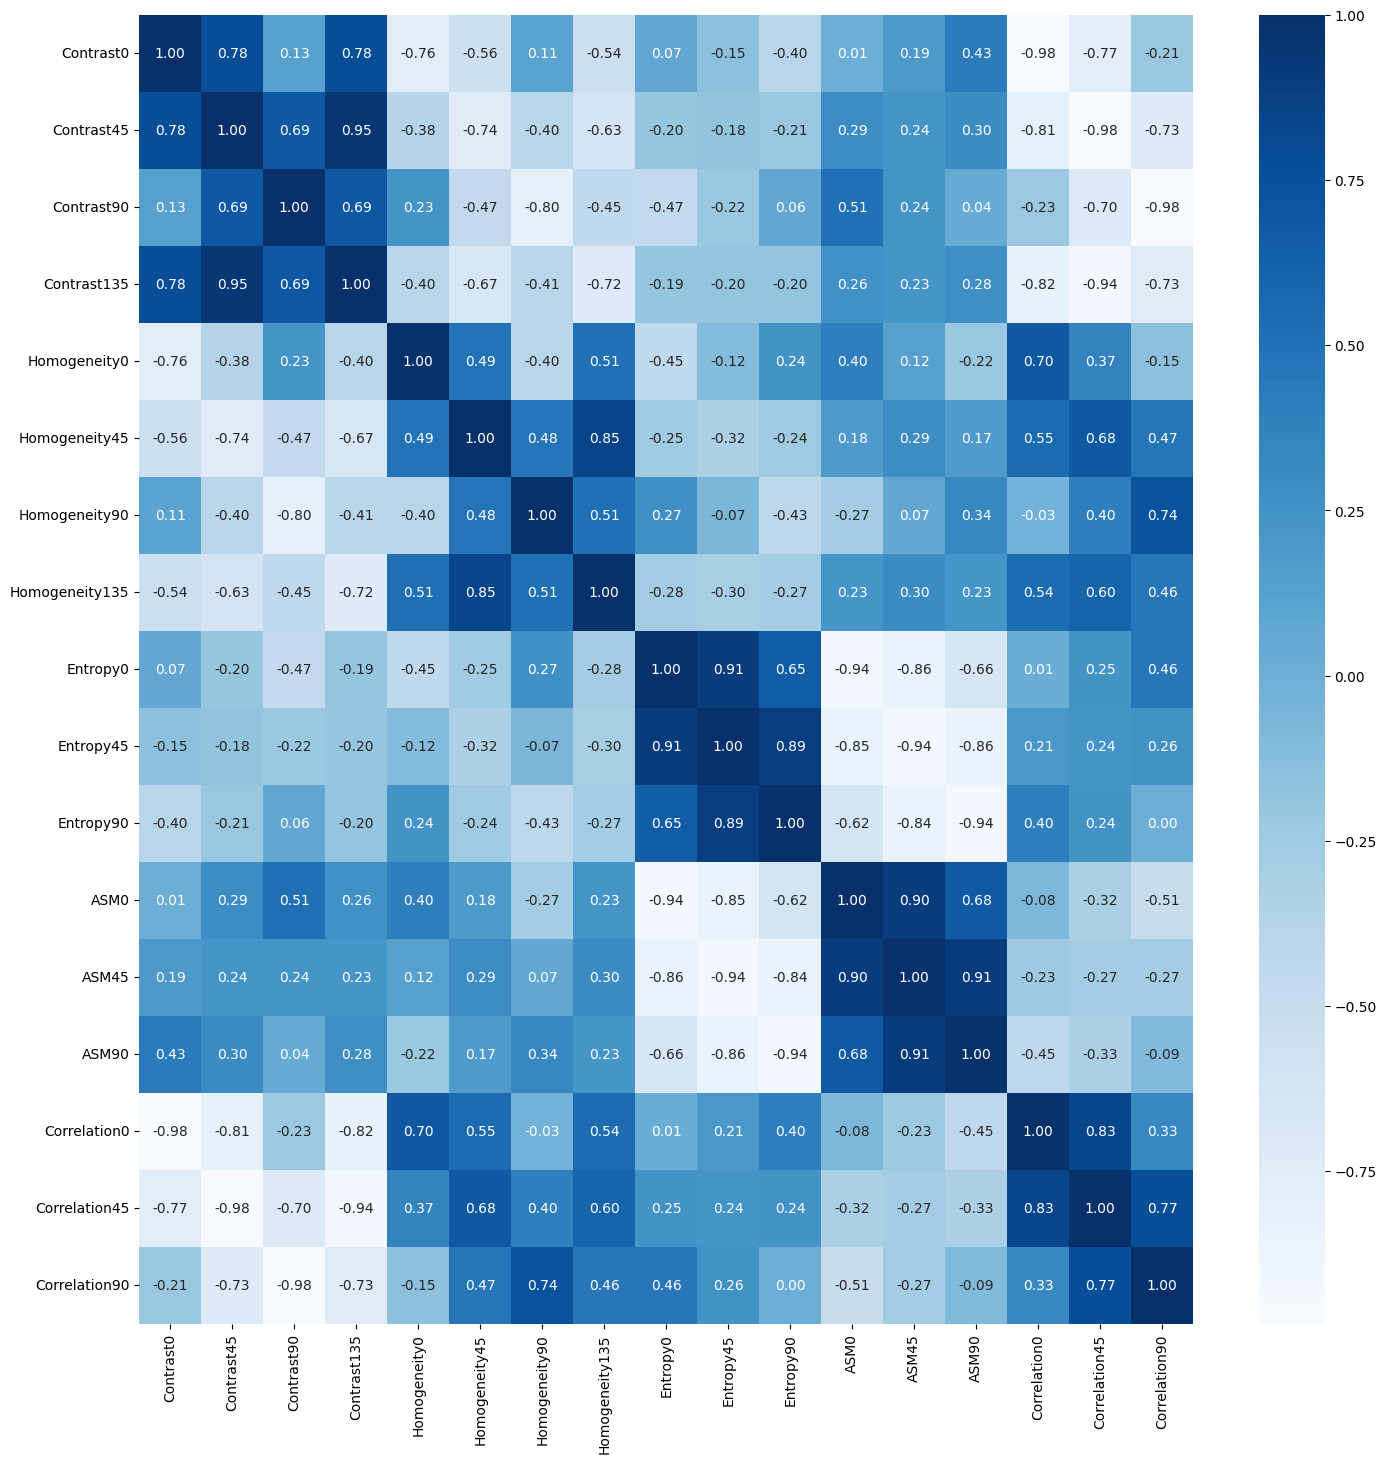

In [36]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

# Splitting data

In [37]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(1015, 17)
(254, 17)


Kode di atas, dilakukan proses pembagian data fitur (x_new) dan label (y) menjadi dua bagian, yaitu data latih (X_train, y_train) dan data uji (X_test, y_test) menggunakan fungsi train_test_split dari scikit-learn. Parameter test_size=0.2 berarti 20% data akan digunakan untuk pengujian (testing), sedangkan sisanya 80% untuk pelatihan (training). Pembagian ini juga menggunakan random_state=42 agar hasil pembagian data konsisten setiap kali dijalankan. Setelah proses split, bentuk (jumlah baris dan kolom) dari data latih dan data uji ditampilkan menggunakan print(X_train.shape) dan print(X_test.shape), sehingga pengguna dapat mengetahui proporsi data yang digunakan untuk pelatihan dan pengujian model.

# Normalisasi Fitur

In [38]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

Kode di atas, dilakukan proses normalisasi fitur pada data latih (X_train) dan data uji (X_test) menggunakan metode standardisasi (mean-std normalization). Setiap nilai fitur dikurangi dengan rata-rata (mean) dan dibagi dengan standar deviasi (std) dari data latih, sehingga menghasilkan distribusi fitur dengan rata-rata nol dan standar deviasi satu. Normalisasi ini penting untuk memastikan semua fitur berada pada skala yang sama, sehingga algoritma machine learning seperti SVM, KNN, dan Random Forest dapat bekerja lebih optimal dan tidak bias terhadap fitur dengan rentang nilai yang lebih besar. Normalisasi juga membantu mempercepat proses konvergensi dan meningkatkan akurasi model.

# Modelling

In [39]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

Kode di atas memilki tiga model klasifikasi machine learning diinisialisasi untuk digunakan dalam proses klasifikasi citra serat kayu, yaitu Random Forest, Support Vector Machine (SVM), dan K-Nearest Neighbors (KNN). Fungsi generateClassificationReport disiapkan untuk menampilkan hasil evaluasi model, yang mencakup classification report (precision, recall, f1-score), confusion matrix, dan nilai akurasi. Random Forest diinisialisasi dengan 5 pohon keputusan (n_estimators=5), SVM menggunakan kernel radial basis function (kernel='rbf'), dan KNN menggunakan 5 tetangga terdekat (n_neighbors=5). Ketiga model ini akan dilatih dan diuji pada data yang telah diproses untuk membandingkan performa klasifikasi masing-masing algoritma.

## Random Forest

Kode di bawah, dilakukan pelatihan (training) model Random Forest menggunakan data latih (X_train, y_train) dengan memanggil fungsi fit. Setelah model dilatih, dilakukan evaluasi performa pada data latih dengan memprediksi label menggunakan predict dan hasilnya dievaluasi menggunakan fungsi generateClassificationReport, yang menampilkan classification report, confusion matrix, dan akurasi. Selanjutnya, model yang sudah dilatih juga diuji pada data uji (X_test) untuk melihat kemampuan generalisasi model terhadap data baru, dan hasil prediksi pada data uji juga dievaluasi dengan cara yang sama. Proses ini bertujuan untuk mengetahui seberapa baik model Random Forest dalam mengenali pola pada data pelatihan dan mengklasifikasikan data yang belum pernah dilihat sebelumnya.

In [40]:
# Train Random Forest
rf.fit(X_train, y_train)

# model training
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# model testing
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

       nantu       0.97      0.99      0.98       331
      palapi       0.99      0.98      0.99       345
         uru       0.99      0.98      0.99       339

    accuracy                           0.99      1015
   macro avg       0.99      0.99      0.99      1015
weighted avg       0.99      0.99      0.99      1015

[[329   1   1]
 [  4 339   2]
 [  5   1 333]]
Accuracy: 0.9862068965517241

------Testing Set------
              precision    recall  f1-score   support

       nantu       0.83      0.91      0.87        92
      palapi       0.87      0.85      0.86        78
         uru       0.84      0.77      0.81        84

    accuracy                           0.85       254
   macro avg       0.85      0.84      0.85       254
weighted avg       0.85      0.85      0.85       254

[[84  2  6]
 [ 6 66  6]
 [11  8 65]]
Accuracy: 0.8464566929133859


## SVM

Kode di bawah, dilakukan pelatihan (training) model Support Vector Machine (SVM) menggunakan data latih (X_train, y_train) dengan memanggil fungsi fit. Setelah model SVM dilatih, performanya dievaluasi pada data latih dengan memprediksi label menggunakan predict, lalu hasilnya dianalisis menggunakan fungsi generateClassificationReport yang menampilkan classification report, confusion matrix, dan akurasi. Selanjutnya, model yang telah dilatih diuji pada data uji (X_test) untuk mengukur kemampuan generalisasi model terhadap data baru, dan hasil prediksi pada data uji juga dievaluasi dengan cara yang sama. Proses ini bertujuan untuk mengetahui seberapa baik model SVM dalam mengenali pola pada data pelatihan dan mengklasifikasikan data yang belum pernah dilihat sebelumnya.

In [41]:
# Train SVM
svm.fit(X_train, y_train)

# model training
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# model testing
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

       nantu       0.74      0.85      0.79       331
      palapi       0.88      0.86      0.87       345
         uru       0.82      0.71      0.76       339

    accuracy                           0.81      1015
   macro avg       0.81      0.81      0.81      1015
weighted avg       0.81      0.81      0.81      1015

[[283  14  34]
 [ 28 298  19]
 [ 73  27 239]]
Accuracy: 0.8078817733990148

------Testing Set------
              precision    recall  f1-score   support

       nantu       0.83      0.89      0.86        92
      palapi       0.91      0.82      0.86        78
         uru       0.81      0.82      0.82        84

    accuracy                           0.85       254
   macro avg       0.85      0.84      0.85       254
weighted avg       0.85      0.85      0.85       254

[[82  1  9]
 [ 7 64  7]
 [10  5 69]]
Accuracy: 0.8464566929133859


## KNN

Kode di bawah, dilakukan pelatihan (training) model K-Nearest Neighbors (KNN) menggunakan data latih (X_train, y_train) dengan memanggil fungsi fit. Setelah model KNN dilatih, performanya dievaluasi pada data latih dengan memprediksi label menggunakan predict, lalu hasilnya dianalisis menggunakan fungsi generateClassificationReport yang menampilkan classification report, confusion matrix, dan akurasi. Selanjutnya, model yang telah dilatih diuji pada data uji (X_test) untuk mengukur kemampuan generalisasi model terhadap data baru, dan hasil prediksi pada data uji juga dievaluasi dengan cara yang sama. Proses ini bertujuan untuk mengetahui seberapa baik model KNN dalam mengenali pola pada data pelatihan dan mengklasifikasikan data yang belum pernah dilihat sebelumnya.

In [42]:
# Train KNN
knn.fit(X_train, y_train)

# model training
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# model testing
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

       nantu       0.81      0.92      0.86       331
      palapi       0.88      0.90      0.89       345
         uru       0.92      0.77      0.84       339

    accuracy                           0.86      1015
   macro avg       0.87      0.86      0.86      1015
weighted avg       0.87      0.86      0.86      1015

[[304  13  14]
 [ 24 312   9]
 [ 49  29 261]]
Accuracy: 0.864039408866995

------Testing Set------
              precision    recall  f1-score   support

       nantu       0.85      0.89      0.87        92
      palapi       0.93      0.88      0.91        78
         uru       0.86      0.85      0.85        84

    accuracy                           0.87       254
   macro avg       0.88      0.87      0.88       254
weighted avg       0.88      0.87      0.87       254

[[82  3  7]
 [ 4 69  5]
 [11  2 71]]
Accuracy: 0.8740157480314961


# Confusion Matrix

Kode ini, dibuat sebuah fungsi bernama plot_confusion_matrix yang digunakan untuk menampilkan confusion matrix dari hasil prediksi model klasifikasi. Fungsi ini menerima tiga parameter, yaitu label sebenarnya (y_true), label hasil prediksi (y_pred), dan judul plot (title). Di dalam fungsi, confusion matrix dihitung menggunakan fungsi confusion_matrix dari scikit-learn, lalu divisualisasikan dengan ConfusionMatrixDisplay dan diberi warna biru menggunakan cmap=plt.cm.Blues agar perbedaan antar kelas lebih mudah dianalisis secara visual. Judul plot ditambahkan sesuai parameter yang diberikan, dan hasil visualisasi confusion matrix ditampilkan menggunakan plt.show().

Selanjutnya, fungsi plot_confusion_matrix dipanggil tiga kali untuk menampilkan confusion matrix dari tiga model berbeda, yaitu Random Forest, SVM, dan KNN, masing-masing menggunakan data uji (y_test) dan hasil prediksi model pada data uji. Visualisasi confusion matrix ini sangat penting dalam evaluasi performa model karena dapat menunjukkan secara detail jumlah prediksi benar dan salah untuk setiap kelas, serta pola kesalahan klasifikasi yang terjadi. Dengan melihat confusion matrix, pengguna dapat mengetahui kelas mana yang sering tertukar, sehingga dapat menjadi bahan evaluasi untuk perbaikan model atau data di tahap selanjutnya.

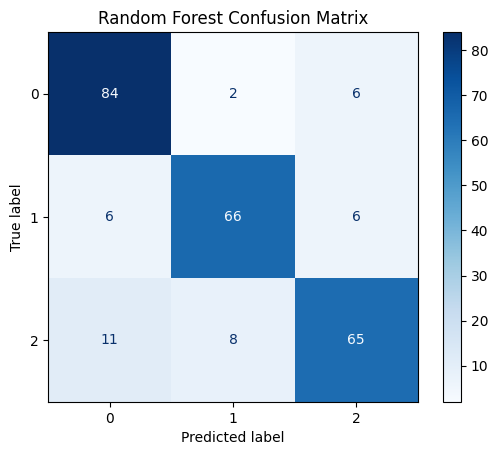

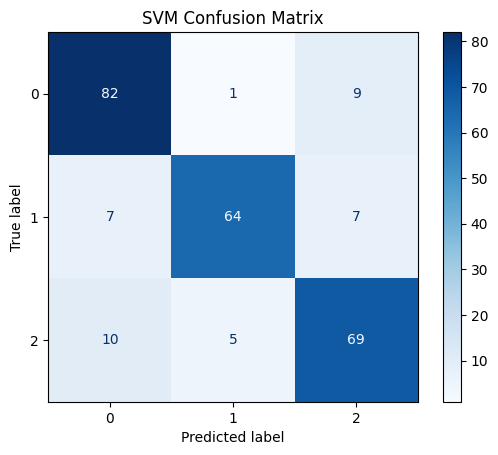

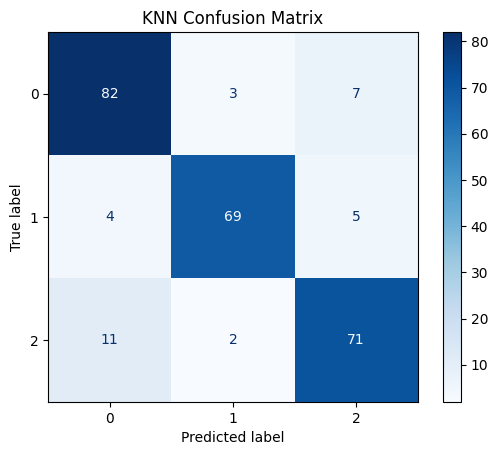

In [43]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# confusion matrix Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# confusion matrix SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# confusion matrix KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")

# Kesimpulan
Proyek ini berhasil membangun sistem klasifikasi otomatis untuk membedakan jenis serat kayu Nantu, Palapi, dan Uru menggunakan metode ekstraksi fitur tekstur berbasis Gray Level Co-occurrence Matrix (GLCM) dan beberapa algoritma machine learning, yaitu Random Forest, Support Vector Machine (SVM), dan K-Nearest Neighbors (KNN). Seluruh tahapan mulai dari preprocessing citra (resize, grayscale, histogram equalization, dan noise reduction), ekstraksi fitur tekstur pada berbagai sudut GLCM, seleksi fitur, normalisasi, hingga pemisahan data latih dan uji telah dilakukan secara sistematis. Evaluasi performa model dilakukan menggunakan classification report dan confusion matrix, sehingga dapat diketahui tingkat akurasi serta pola kesalahan klasifikasi pada masing-masing model.

Hasil pengujian menunjukkan bahwa ketiga model mampu mengenali pola tekstur serat kayu dengan tingkat akurasi yang baik, meskipun terdapat perbedaan performa di antara model. Visualisasi confusion matrix membantu dalam menganalisis kelas mana yang sering tertukar dan menjadi dasar untuk perbaikan lebih lanjut, baik pada sisi data maupun pemilihan fitur. Dengan pendekatan ini, proses identifikasi jenis kayu menjadi lebih objektif, efisien, dan dapat diandalkan untuk mendukung kebutuhan industri pengolahan kayu.